<a href="https://colab.research.google.com/github/hugol1212/Fundamentos/blob/main/Pr%C3%A1ctica4_1b_alumnos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica: Tensores y sus Aplicaciones
En esta práctica, trabajaremos con tensores desde su matricización hasta su aplicación práctica para la compresión de datos.

### Objetivos
1. Entender cómo vectorizar y matriciar un tensor.
2. Construir tensores a partir de tensores de rango 1 usando el producto externo.
3. Implementar el modelo PARAFAC para descomposición tensorial.
4. Aplicar tensores para la compresión de un vídeo.

## 3.1. Implementación del Modelo PARAFAC con CVX
El modelo PARAFAC descompone un tensor en una suma de productos externos de vectores. Esto equivale a descomponer el tensor en matrices \(A\), \(B\), y \(C\).

Iter   0 | Reconstruction error: 2.102619e+00
Iter   1 | Reconstruction error: 1.964389e+00
Iter   2 | Reconstruction error: 2.074063e+00
Iter   3 | Reconstruction error: 2.037435e+00
Iter   4 | Reconstruction error: 2.170408e+00
Iter   5 | Reconstruction error: 2.175704e+00
Iter   6 | Reconstruction error: 2.027022e+00
Iter   7 | Reconstruction error: 1.984659e+00
Iter   8 | Reconstruction error: 1.999860e+00
Iter   9 | Reconstruction error: 1.950053e+00
Iter  10 | Reconstruction error: 1.885777e+00
Iter  11 | Reconstruction error: 1.985664e+00
Iter  12 | Reconstruction error: 2.242696e+00
Iter  13 | Reconstruction error: 2.172822e+00
Iter  14 | Reconstruction error: 1.977755e+00
Iter  15 | Reconstruction error: 2.114886e+00
Iter  16 | Reconstruction error: 2.048250e+00
Iter  17 | Reconstruction error: 2.075872e+00
Iter  18 | Reconstruction error: 1.998599e+00
Iter  19 | Reconstruction error: 2.047247e+00
Iter  20 | Reconstruction error: 1.973368e+00
Iter  21 | Reconstruction error: 1

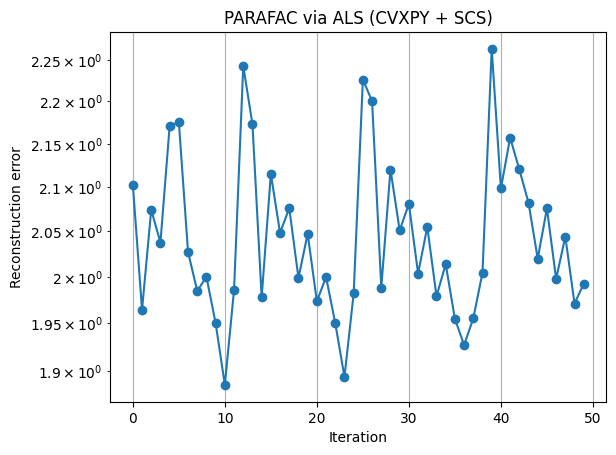

In [4]:
import numpy as np
import cvxpy as cp
from scipy.linalg import khatri_rao
import matplotlib.pyplot as plt

# --------------------------------------------------
# PARAFAC / CP Decomposition via ALS using CVXPY
# (block coordinate descent: update A, then B, then C)
# NOTE: ECOS is not installed in your environment, so we use SCS
# --------------------------------------------------

# --------------------------------------------------
# Tensor dimensions
# --------------------------------------------------
I, J, K, F = 3, 4, 5, 2   # I x J x K tensor, CP rank F
np.random.seed(0)

# --------------------------------------------------
# Generate a random tensor X (data to factorize)
# --------------------------------------------------
X = np.random.rand(I, J, K)

# --------------------------------------------------
# Mode-n unfoldings (matricizations)
# X1: I x (J*K)
# X2: J x (I*K)
# X3: K x (I*J)
# --------------------------------------------------
X1 = X.reshape(I, -1)
X2 = np.moveaxis(X, 1, 0).reshape(J, -1)
X3 = np.moveaxis(X, 2, 0).reshape(K, -1)

# --------------------------------------------------
# Initialization (ONCE) for factor matrices
# A: I x F, B: J x F, C: K x F
# --------------------------------------------------
A_val = np.random.rand(I, F)
B_val = np.random.rand(J, F)
C_val = np.random.rand(K, F)

# --------------------------------------------------
# CVXPY variables (optimization variables)
# --------------------------------------------------
A = cp.Variable((I, F))
B = cp.Variable((J, F))
C = cp.Variable((K, F))

# --------------------------------------------------
# ALS loop
# --------------------------------------------------
max_iter = 50
errors = []

for it in range(max_iter):

    # ==================================================
    # Update A  (solve: min || X1 - A (C ⊙ B)^T ||_F^2 )
    # ==================================================
    Z = khatri_rao(C_val, B_val)  # (K*J, F) -> matches X1 columns (J*K)
    problem_A = cp.Problem(cp.Minimize(cp.norm(X1 - A @ Z.T, "fro")**2))
    A.value = A_val  # warm start
    problem_A.solve(solver=cp.SCS, warm_start=True, verbose=False)
    A_val = A.value

    # ==================================================
    # Update B  (solve: min || X2 - B (C ⊙ A)^T ||_F^2 )
    # ==================================================
    Z = khatri_rao(C_val, A_val)  # (K*I, F) -> matches X2 columns (I*K)
    problem_B = cp.Problem(cp.Minimize(cp.norm(X2 - B @ Z.T, "fro")**2))
    B.value = B_val  # warm start
    problem_B.solve(solver=cp.SCS, warm_start=True, verbose=False)
    B_val = B.value

    # ==================================================
    # Update C  (solve: min || X3 - C (B ⊙ A)^T ||_F^2 )
    # ==================================================
    Z = khatri_rao(B_val, A_val)  # (J*I, F) -> matches X3 columns (I*J)
    problem_C = cp.Problem(cp.Minimize(cp.norm(X3 - C @ Z.T, "fro")**2))
    C.value = C_val  # warm start
    problem_C.solve(solver=cp.SCS, warm_start=True, verbose=False)
    C_val = C.value

    # --------------------------------------------------
    # Normalize columns to reduce scale ambiguity:
    # (you could normalize all A,B,C, but this is enough)
    # --------------------------------------------------
    for f in range(F):
        n = np.linalg.norm(A_val[:, f])
        if n > 0:
            A_val[:, f] /= n
            B_val[:, f] *= n

    # --------------------------------------------------
    # Reconstruction error: ||X - X_hat||_F
    # X_hat[i,j,k] = sum_f A[i,f] B[j,f] C[k,f]
    # --------------------------------------------------
    X_hat = np.einsum("if,jf,kf->ijk", A_val, B_val, C_val)
    err = np.linalg.norm(X - X_hat)
    errors.append(err)

    print(f"Iter {it:3d} | Reconstruction error: {err:.6e}")

# --------------------------------------------------
# Final results
# --------------------------------------------------
print("\nFinal factor matrices:")
print("A:\n", A_val)
print("B:\n", B_val)
print("C:\n", C_val)

# --------------------------------------------------
# Error plot
# --------------------------------------------------
plt.figure()
plt.plot(errors, marker="o")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Reconstruction error")
plt.title("PARAFAC via ALS (CVXPY + SCS)")
plt.grid(True)
plt.show()



## 3.2. Implementación del Modelo PARAFAC mediante Alternating Least Squares (ALS)

Iter   0 | Reconstruction error: 4.641747e-01
Iter   1 | Reconstruction error: 4.336589e-01
Iter   2 | Reconstruction error: 4.578707e-01
Iter   3 | Reconstruction error: 4.497847e-01
Iter   4 | Reconstruction error: 4.791398e-01
Iter   5 | Reconstruction error: 4.803090e-01
Iter   6 | Reconstruction error: 4.474860e-01
Iter   7 | Reconstruction error: 4.381337e-01
Iter   8 | Reconstruction error: 4.414896e-01
Iter   9 | Reconstruction error: 4.304942e-01
Iter  10 | Reconstruction error: 4.163046e-01
Iter  11 | Reconstruction error: 4.383557e-01
Iter  12 | Reconstruction error: 4.950978e-01
Iter  13 | Reconstruction error: 4.796732e-01
Iter  14 | Reconstruction error: 4.366103e-01
Iter  15 | Reconstruction error: 4.668841e-01
Iter  16 | Reconstruction error: 4.521741e-01
Iter  17 | Reconstruction error: 4.582702e-01
Iter  18 | Reconstruction error: 4.412117e-01
Iter  19 | Reconstruction error: 4.519510e-01
Iter  20 | Reconstruction error: 4.356411e-01
Iter  21 | Reconstruction error: 4

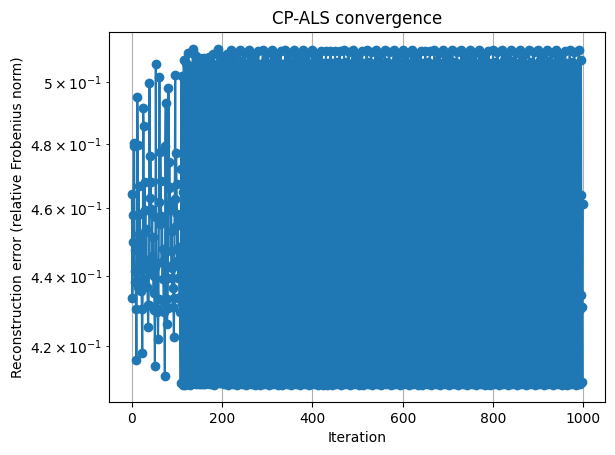

[np.float64(0.4641746871859477), np.float64(0.4336589351358477), np.float64(0.45787067365954665), np.float64(0.44978469297001145), np.float64(0.47913980951329715), np.float64(0.48030901345407256), np.float64(0.44748598437718934), np.float64(0.43813372506355597), np.float64(0.4414895702092752), np.float64(0.4304942410089335), np.float64(0.4163045630897424), np.float64(0.43835568215647325), np.float64(0.4950978203011103), np.float64(0.479673222455552), np.float64(0.43661025029521366), np.float64(0.46688412426656273), np.float64(0.45217409769118067), np.float64(0.45827016810125276), np.float64(0.4412117418587358), np.float64(0.45195100977725694), np.float64(0.43564112998720783), np.float64(0.4414677418271441), np.float64(0.43049714460034916), np.float64(0.4180969636382478), np.float64(0.43753356751174055), np.float64(0.4914409916035929), np.float64(0.4857192060815179), np.float64(0.4389292228641263), np.float64(0.4679956252779763), np.float64(0.45277628954026167), np.float64(0.45934793944

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import khatri_rao

# -----------------------------
# Problem dimensions
# -----------------------------
I, J, K, F = 3, 4, 5, 2
np.random.seed(0)

# Tensor
X = np.random.rand(I, J, K)

# -----------------------------
# Mode-n unfoldings (correct)
# X1: I x (J*K)
# X2: J x (I*K)
# X3: K x (I*J)
# -----------------------------
X1 = X.reshape(I, -1)
X2 = np.moveaxis(X, 1, 0).reshape(J, -1)
X3 = np.moveaxis(X, 2, 0).reshape(K, -1)

# -----------------------------
# Initialization
# -----------------------------
A = np.random.rand(I, F)
B = np.random.rand(J, F)
C = np.random.rand(K, F)

# -----------------------------
# CP-ALS
# -----------------------------
max_iter = 1000
tol = 1e-6
errors = []   # store errors

for it in range(max_iter):

    # ---- Update A ----
    # X1 ≈ A (C ⊙ B)^T  -> Z = (C ⊙ B) has shape (K*J, F)
    Z = khatri_rao(C, B)                                # (K*J, F)
    A = np.linalg.lstsq(Z, X1.T, rcond=None)[0].T       # (I, F)

    # ---- Update B ----
    # X2 ≈ B (C ⊙ A)^T  -> Z = (C ⊙ A) has shape (K*I, F)
    Z = khatri_rao(C, A)                                # (K*I, F)
    B = np.linalg.lstsq(Z, X2.T, rcond=None)[0].T       # (J, F)

    # ---- Update C ----
    # X3 ≈ C (B ⊙ A)^T  -> Z = (B ⊙ A) has shape (J*I, F)
    Z = khatri_rao(B, A)                                # (J*I, F)
    C = np.linalg.lstsq(Z, X3.T, rcond=None)[0].T       # (K, F)

    # ---- Normalize columns ----
    for f in range(F):
        norm = np.linalg.norm(A[:, f])
        if norm > 0:
            A[:, f] /= norm
            B[:, f] *= norm

    # ---- Reconstruction error (relative Frobenius norm) ----
    X_hat = np.einsum('if,jf,kf->ijk', A, B, C)
    error = np.linalg.norm(X - X_hat) / np.linalg.norm(X)
    errors.append(error)

    print(f"Iter {it:3d} | Reconstruction error: {error:.6e}")

    # Stopping criterion
    if error < tol:
        print("It is over")
        break

# -----------------------------
# Plot error evolution
# -----------------------------
plt.figure()
plt.plot(errors, marker='o')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Reconstruction error (relative Frobenius norm)")
plt.title("CP-ALS convergence")
plt.grid(True)
plt.show()

print(errors)


## 3.3. Implementación del Modelo PARAFAC mediante tensorly

In [2]:
pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 25.5 MB/s eta 0:00:00


In [7]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import parafac

# Use NumPy backend
tl.set_backend('numpy')

# Tensor dimensions
I, J, K = 3, 4, 5
rank = 5

# Random tensor
X = np.random.rand(I, J, K)

# CP / PARAFAC decomposition
weights, factors = parafac(
    X,
    rank=rank,
    n_iter_max=100,
    tol=1e-6,
    init='random',
    normalize_factors=False,
    verbose=1
)

# Factors
A, B, C = factors

print("A shape:", A.shape)
print("B shape:", B.shape)
print("C shape:", C.shape)

from tensorly.cp_tensor import cp_to_tensor

X_hat = cp_to_tensor((weights, factors))

error = tl.norm(X - X_hat) / tl.norm(X)
print("Relative reconstruction error:", error)

reconstruction error=0.3022237921449272
iteration 1, reconstruction error: 0.2445436456087236, decrease = 0.05768014653620357, unnormalized = 1.1282918727396682
iteration 2, reconstruction error: 0.2314639182446951, decrease = 0.013079727364028515, unnormalized = 1.0679437494189878
iteration 3, reconstruction error: 0.21997284472517847, decrease = 0.011491073519516615, unnormalized = 1.014925463751204
iteration 4, reconstruction error: 0.21085398955376958, decrease = 0.009118855171408896, unnormalized = 0.9728522781937555
iteration 5, reconstruction error: 0.20493118889167733, decrease = 0.005922800662092248, unnormalized = 0.9455252632788465
iteration 6, reconstruction error: 0.20034616397350666, decrease = 0.0045850249181706715, unnormalized = 0.924370567810872
iteration 7, reconstruction error: 0.19579051777416123, decrease = 0.004555646199345426, unnormalized = 0.9033514218461345
iteration 8, reconstruction error: 0.19085707461773455, decrease = 0.004933443156426687, unnormalized =

## 3.4. Tucker usando HOSVD

In [6]:
import numpy as np
from numpy.linalg import svd

# -----------------------------
# Tensor and Tucker ranks
# -----------------------------
I, J, K = 6, 5, 4
R1, R2, R3 = 3, 3, 2
np.random.seed(0)

X = np.random.rand(I, J, K)

# Mode-n unfoldings
X1 = X.transpose(0, 2, 1).reshape(I, -1)      # (I, KJ)
X2 = X.transpose(1, 2, 0).reshape(J, -1)      # (J, KI)
X3 = X.transpose(2, 1, 0).reshape(K, -1)      # (K, JI)

# SVDs
U1, _, _ = svd(X1, full_matrices=False)
U2, _, _ = svd(X2, full_matrices=False)
U3, _, _ = svd(X3, full_matrices=False)

A = U1[:, :R1]
B = U2[:, :R2]
C = U3[:, :R3]

# Core tensor
G = np.einsum('ia,jb,kc,ijk->abc', A, B, C, X)

# Reconstruction
X_hat = np.einsum('ia,jb,kc,abc->ijk', A, B, C, G)

error = np.linalg.norm(X - X_hat) / np.linalg.norm(X)
print("Reconstruction error (HOSVD):", error)

Reconstruction error (HOSVD): 0.35256378696432805


## 3.5 Tucker usando tensorly

In [8]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor

tl.set_backend('numpy')

# -----------------------------
# Tensor and Tucker ranks
# -----------------------------
I, J, K = 6, 5, 4
ranks = (4, 4, 4)
np.random.seed(0)

X = np.random.rand(I, J, K)

# Tucker decomposition
core, factors = tucker(
    X,
    rank=ranks,
    init='svd',
    n_iter_max=100,
    tol=1e-6
)

A, B, C = factors

# Reconstruction
X_hat = tucker_to_tensor((core, factors))

error =  tl.norm(X - X_hat) / tl.norm(X)
print("Reconstruction error (TensorLy Tucker):", error)

Reconstruction error (TensorLy Tucker): 0.20032628074348202
